# Out-of-Core Dataframes in Python: Dask and OpenStreetMap

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

<!-- PELICAN_BEGIN_SUMMARY -->

In recent months, a host of new tools and packages have been announced for working with data at scale in Python.
For an excellent and entertaining summary of these, I'd suggest watching Rob Story's [Python Data Bikeshed](https://www.youtube.com/watch?v=RTiAMB2tQjo) talk from the [2015 PyData Seattle](http://seattle.pydata.org) conference.
Many of these new scalable data tools are relatively heavy-weight, involving brand new data structures or interfaces to other computing environments, but [Dask](http://dask.pydata.org/) stands out for its simplicity.
Dask is a light-weight framework for working with chunked arrays or dataframes across a variety of computational backends.
Under the hood, Dask simply uses standard Python, NumPy, and Pandas commands on each chunk, and transparently executes operations and aggregates results so that you can work with datasets that are larger than your machine's memory.

In this post, I'll take a look at how dask can be useful when looking at a large dataset: the full extracted points of interest from OpenStreetMap.
We will use Dask to manipulate and explore the data, and also see the use of matplotlib's [Basemap](http://matplotlib.org/basemap/) toolkit to visualize the results on a map.

<!-- PELICAN_END_SUMMARY -->

## The Data: OpenStreetMap

The data we will be looking at here is the extracted database of marked locations in [Open Street Map](http://openstreetmap.org).
OpenStreetMap is a free and open, crowd-sourced online mapping tool, meaning that everything on it has been added by an individual user.
This has resulted in a compiled collection of nearly ten million distinct points of interest, comprising everything from post boxes to restaurants to historical sites to park benches.

An extracted table of data on these points of interest can be found on the [OSM-x-tractor](http://osm-x-tractor.org/Data.aspx) site, a free project which compiles these points of interest and makes them available in a variety of common formats.
For this post, I downloaded the CSV file for World Points of Interest, and extracted the compressed file into ``"POIWorld.csv"``, a standard comma-separated value file.

This file has just over nine million lines, each of which corresponds to a specific point of interest:

In [1]:
nrows = sum(1 for _ in open('POIWorld.csv'))
nrows

9140114

Using command-line tools, we can also see that the size of the file is about 760MB.

In [2]:
!ls -lh POIWorld.csv

-rw-r--r--  1 jakevdp  staff   761M Jul 14 14:10 POIWorld.csv


While this could fit into memory on most modern machines, here we'll take a more scalable approach, utilizing Dask to do our data ingestion and manipulation out-of-core.
The benefit is that the approach used here will straightforwardly scale to even larger datasets analyzed across multiple machines.

Before we begin to look at this data, let's take a look at Dask and how it can help us with this problem.

## Dask Basics

[Dask](http://dask.pydata.org/), fundamentally, is a lightweight generator of task graphs for Python.
A task graph is a way of describing a sequence of operations so that they can be executed at a later point.
By building these task graphs, Dask describes the exact sequence of inputs, operations, and outputs that your algorithm requires, and can send this description to a variety of backends for efficient parallel and/or out-of-core computation.

Though the low-level details are interesting, it is the higher-level interfaces that most people will use.
These interfaces are:

- ``dask.bag``: create task graphs using a functional programming style
- ``dask.array``: create task graphs using a NumPy-like array interface
- ``dask.dataframe``: create task graphs using a Pandas-like DataFrame interface

Each of these provides a familiar Python interface for operating on data, with the difference that individual operations build graphs rather than computing results; the results must be explicitly extracted with a call to the ``compute()`` method.
As an example of Dask in action, let's take a look at an example of using ``dask.array``.

### Dask Arrays

First, let's do a sequence of simple array operations using standard NumPy tools:

In [3]:
import numpy as np

# create an array of normally-distributed random numbers
a = np.random.randn(1000)

# multiply this array by a factor
b = a * 4

# find the minimum value
b_min = b.min()
print(b_min)

-11.4051061336


Dask allows us to use very similar code to build a task graph describing these operations:

In [4]:
import dask.array as da

# create a dask array from the above array
a2 = da.from_array(a, chunks=200)

# multiply this array by a factor
b2 = a2 * 4

# find the minimum value
b2_min = b2.min()
print(b2_min)

dask.array<x_3, shape=(), chunks=(), dtype=float64>


In this case, the result of the computation is not a *value*, but is instead a Dask array object which contains the sequence of steps needed to compute that value.

If you have the graphviz package installed (``pip install graphviz``), you can visualize this sequence of steps on this chunked data:

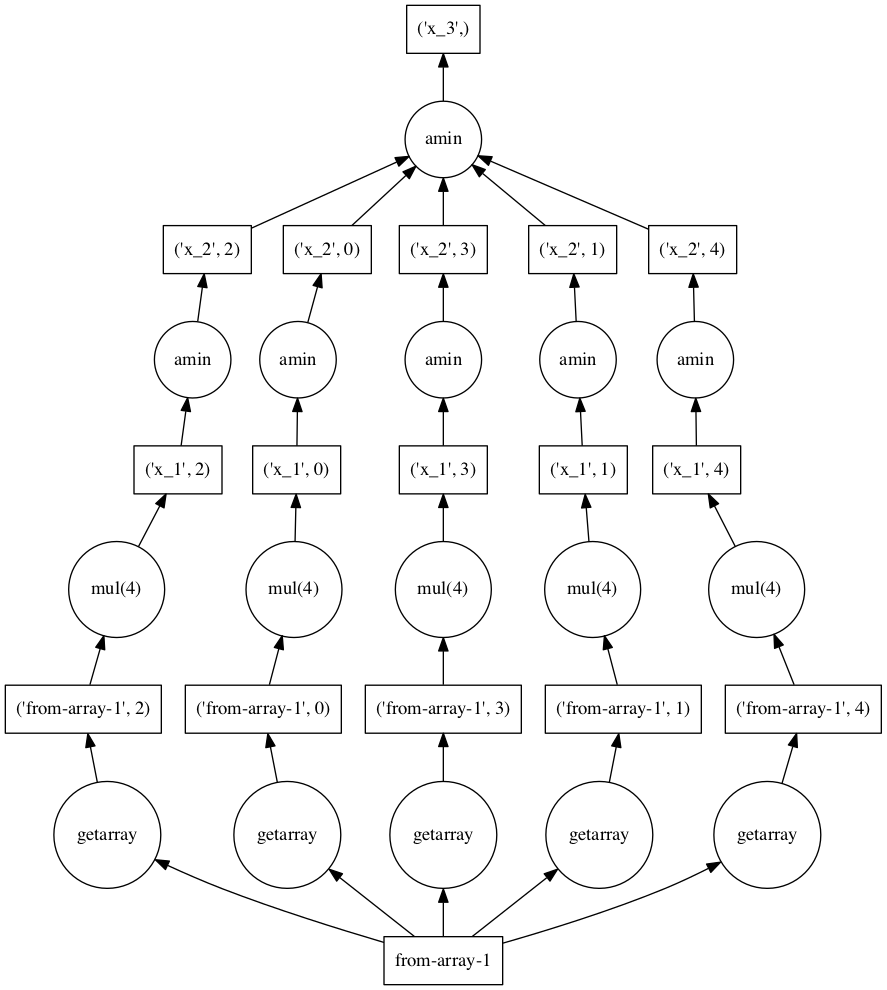

In [5]:
from dask.dot import dot_graph
dot_graph(b2_min.dask)

Reading from the bottom to the top, this graph shows exactly what will happen with our computation: first the array ``x`` is ingested by ``dd.from_array`` and split into five chunks of 200 elements.
Each of these chunks is multiplied by 4, and the minimum value is found.
Finally, the global minimum is found among these chunk-wise minima, and the result is returned.

We can tell Dask to compute the result encoded in this graph using the ``compute()`` method of the dask object:

In [6]:
b2_min.compute()

-11.405106133564583

As expected, we get the same result as the normal, non-lazy method.

I'm not going to go into any more technical details of Dask here, but you should be aware that it contains many more options for flexible creation and evaluation of such task graphs.
For more information, I'd suggest reading through the [dask documentation](http://dask.pydata.org/) or watching the excellent [Dask tutorial](https://www.youtube.com/watch?v=ieW3G7ZzRZ0) given by Matthew Rocklin at the recent [PyData Seattle](http://seattle.pydata.org/) conference.

## Dask DataFrames and OpenStreetMap

With this framework of *task graphs* plus *lazy evaluation*, let's take a look at using Dask in a more interesting context: exploring the OpenStreetMap data.

We can start by taking a look at the first few rows of the data using Pandas, just to see what we're working with:

In [7]:
import pandas as pd
data = pd.read_csv('POIWorld.csv', nrows=5)
data.columns

Index(['﻿"osmid"', 'name', 'amenity', 'emergency', 'historic', 'leisure',
       'man_made', 'office', 'shop', 'sport', 'tourism', 'craft', 'Longitude',
       'Latitude'],
      dtype='object')

Each point of interest has latitude and longitude, along with a variety of other data labels.
We'll extract these locations, and focus on the "name" and "amenity" columns associated with them.
This can be done with Dask's version of Pandas' ``read_csv`` command:

In [8]:
from dask import dataframe as dd
columns = ["name", "amenity", "Longitude", "Latitude"]
data = dd.read_csv('POIWorld.csv', usecols=columns)
data

dd.DataFrame<read-csv-POIWorld.csv-ea29fef3df6f73002fe27223a3749930, divisions=(None, None, None, ..., None, None)>

Notice here that the ``read_csv`` command did not actually open the file and access the data, but simply created a task graph describing the operations needed to access the data.

Next let's use a Pandas-style filtering to select two subsets of this data: those rows with "amenity" specified, and those rows with "name" specified:

In [9]:
with_name = data[data.name.notnull()]
with_amenity = data[data.amenity.notnull()]

Once again, we have not yet done any actual computation, but simply specified how to find the part of the data we're interested in.

## Diving Into the Data: Geography of Coffee

One thing we can do with this data is pull-out certain points of interest and compare their distribution on a map.
Here we'll try to reproduce a recent [Reddit Post](https://www.reddit.com/r/MapPorn/comments/2s2a3f/coffee_shop_geography_starbucks_vs_dunkin_donuts/) which maps the distribution of Dunkin Donuts and Starbucks locations in the US.

First, we must further filter the data by the name column.
Dask lets us use Pandas-style masking and vectorized string operations, so we can do this as follows:

In [10]:
is_starbucks = with_name.name.str.contains('[Ss]tarbucks')
is_dunkin = with_name.name.str.contains('[Dd]unkin')

starbucks = with_name[is_starbucks]
dunkin = with_name[is_dunkin]

To see how many results we have, we can use a ``count()`` call and pass it to ``dd.compute()`` to see the results.
This is the point when we are finally actually loading the data and computing quantities from the values:

In [11]:
dd.compute(starbucks.name.count(), dunkin.name.count())

(5301, 1276)

We find about 5300 Starbucks and 1300 Dunkin Donuts locations in the global dataset; this is far fewer than the true numbers for these chains, which are around [12000 Starbucks and 8000 Dunkin Donuts](https://www.factual.com/data/t/restaurants-us) in the United States alone!
Evidently, the OpenStreetMap data is not all that complete.
From my own anecdotal experience with the dataset, I've found that the data tends to be fairly complete in dense urban areas, while missing many details in more sparsely-populated locations.

Despite this incompleteness, let's push-on with the data we have and see what we can discover.
We can start by computing and extracting the latitude and longitude from the graphs we have generated.
We will do this in a single ``dd.compute()`` call, so that the data will be ingested only once:

In [12]:
locs = dd.compute(starbucks.Longitude,
                  starbucks.Latitude,
                  dunkin.Longitude,
                  dunkin.Latitude)

# extract arrays of values fro the series:
lon_s, lat_s, lon_d, lat_d = [loc.values for loc in locs]

Now that we have this data, we can use matplotlib's [basemap](http://matplotlib.org/basemap/) toolkit to visualize the results on a map:

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def draw_USA():
    """initialize a basemap centered on the continental USA"""
    plt.figure(figsize=(14, 10))
    return Basemap(projection='lcc', resolution='l',
                   llcrnrlon=-119, urcrnrlon=-64,
                   llcrnrlat=22, urcrnrlat=49,
                   lat_1=33, lat_2=45, lon_0=-95,
                   area_thresh=10000)

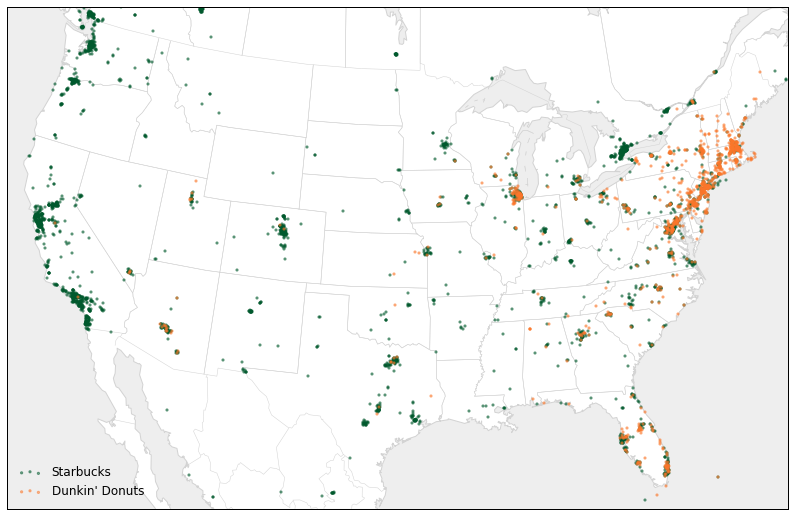

In [14]:
m = draw_USA()
    
# Draw map background
m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')

# Plot the values in Starbucks Green and Dunkin Donuts Orange
style = dict(s=5, marker='o', alpha=0.5, zorder=2)
m.scatter(lon_s, lat_s, latlon=True,
          label="Starbucks", color='#00592D', **style)
m.scatter(lon_d, lat_d, latlon=True,
          label="Dunkin' Donuts", color='#FC772A', **style)
plt.legend(loc='lower left', frameon=False);

Again, these data are far from complete, but we can nevertheless see the general trend that many have noted before: Starbucks favors the west coast, while Dunkin Donuts favors the east coast.
For anybody who has spent much time in, say, Seattle and Boston, this overall trend should not be all that surprising!

## Fast Food Nation

Let's look at a different set of this data, via the "amenity" column.
We can call the ``count()`` method to check how many rows of the data have ``amenity`` specified:

In [15]:
dd.compute(with_amenity.amenity.count())

(5075909,)

We see just over five million rows with an amenity label.
With Pandas' ``value_counts()`` function, we can examine the most common of these labels in the dataset.
Here the ``head()`` call triggers a computation:

In [16]:
with_amenity.amenity.value_counts().head(20)

bench               492190
restaurant          400620
place_of_worship    389266
school              335937
parking             282460
fuel                198865
post_box            181858
cafe                156946
bank                152218
fast_food           146962
recycling           135912
pharmacy            127259
waste_basket        119881
grave_yard          118324
bicycle_parking     110657
post_office         102431
drinking_water       94594
pub                  94416
toilets              93708
telephone            90894
dtype: int64

Somewhat surprisingly, there are far more benches labeled than any other single labeled object.

Down the list a bit, we see the ``fast_food`` category, which has around 150,000 global entries.
Using a filter plus another value count, we can check which fast food restaurants are most common:

In [17]:
is_fastfood = with_amenity.amenity.str.contains('fast_food')
fastfood = with_amenity[is_fastfood]
fastfood.name.value_counts().head(12)

McDonald's        8608
Subway            6784
Burger King       3180
KFC               2812
Wendy's           1301
Taco Bell         1272
Pizza Hut          965
マクドナルド             918
Dairy Queen        744
Domino's Pizza     680
McDonalds          634
Arby's             606
dtype: int64

As an aside, one interesting thing we see is that there are three versions of McDonald's in this list: there are "McDonald's", and "McDonalds", of course, but also マクドナルド (roughly pronounced "Makudonarudo"), which is the Japanese adaptation of the well-known restaurant name.
If you were attempting to use this dataset to count locations by chain, it would be important to take these multiple similar labels into account!

Let's next take a look at the full collection of fast food restaurant locations, extract their latitude and longitude coordinates, and plot their locations on a map of the USA:

In [18]:
lat, lon = dd.compute(fastfood.Latitude,
                      fastfood.Longitude)

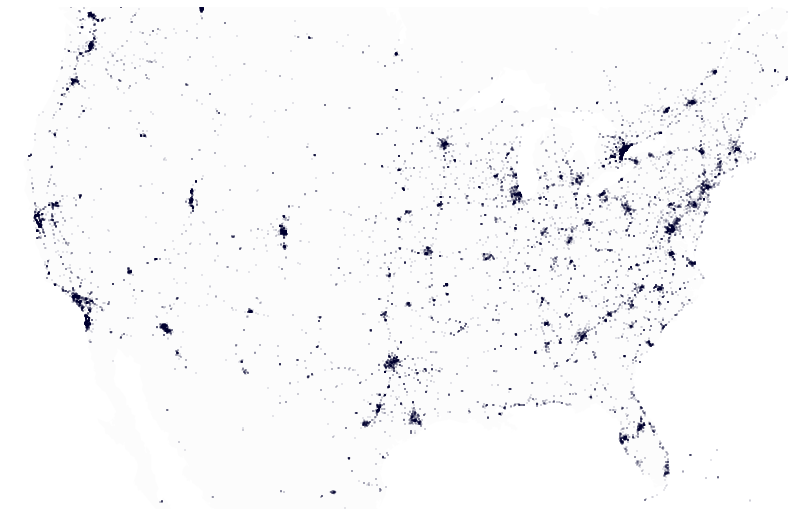

In [19]:
m = draw_USA()
    
m.drawmapboundary(fill_color='#ffffff', linewidth=0)
m.fillcontinents(color="#fcfcfc", lake_color='#ffffff', zorder=1)

m.scatter(lon.values, lat.values, latlon=True,
          s=1, marker='o', alpha=0.1, zorder=2);

Here I've purposely left-out the geographical borders; we see that with fast food locations alone, we can see the major cities, and even trace-out some of the major interstate routes!
I suspect that, like above, this data is far from complete, especially in more rural areas.
I would love to see how a *full* fast-food-nation map would look, but after poking around it seems that most available data on that is proprietary (though FlowingData has an [interesting visualization](http://flowingdata.com/2014/06/24/burger-place-geography/) in the same spirit).

## Pubs of the British Isles

Let's take a look at one last example, reproducing a [post](http://ramiro.org/notebook/mapping-pubs/?imm_mid=0d697c&cmp=em-data-na-na-newsltr_20150812) by Ramiro Gomez, a developer in Berlin whose website is definitely worth clicking around for a bit.
Here we will extract all the pub locations from the dataset, and use them to visualize a small island nation with an astounding density of these establishments.

We'll start by filtering the amenities for the word "pub" (being careful to use regular expressions which mark word boundaries, so that we don't match things like "public toilet"):

In [20]:
is_pub = with_amenity.amenity.str.contains(r'\bpub\b')
pubs = with_amenity[is_pub]
pubs.amenity.count().compute()

94478

We have about 95,000 world-wide points of interest with "pub" in the label.

Next, as above, we can extract the longitude and latitude arrays from our data:

In [21]:
lon, lat = dd.compute(pubs.Longitude, pubs.Latitude)

Finally, with a few lines of Basemap code, we can visualize the results:

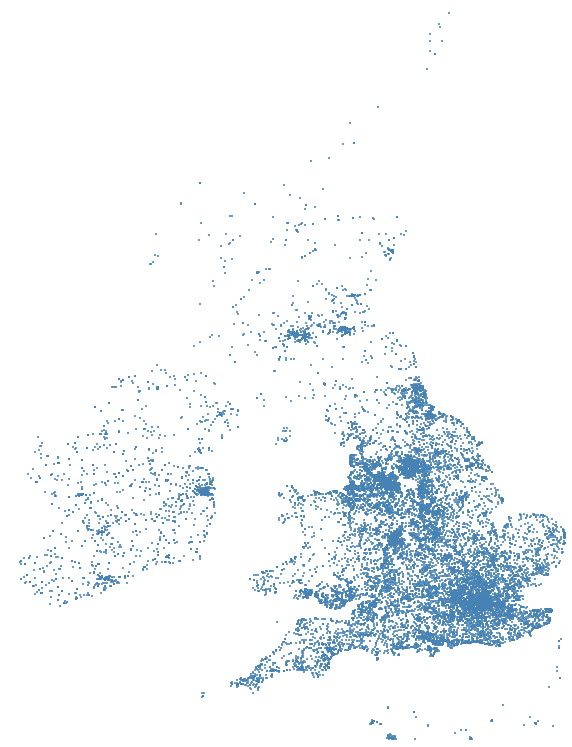

In [22]:
fig, ax = plt.subplots(figsize=(10, 15))
m = Basemap(projection='mill',
            lon_0=-5.23636, lat_0=53.866772,
            llcrnrlon=-10.65073, llcrnrlat=49.16209,
            urcrnrlon=1.76334, urcrnrlat=60.860699)
m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
x, y = m(lon.values, lat.values)
m.scatter(x, y, s=1, marker=',', color="steelblue", alpha=0.8);

The pub locations alone are enough to make out most of the borders and contours of the islands!

---

The above visualizations are fun, but have merely scraped the surface of what can be done with this data – what interesting geographical visualizations can you come up with using these data and tools?

Thanks for reading!

*This post was written entirely in the IPython notebook.  You can [download](http://jakevdp.github.io/downloads/notebooks/OutOfCoreMapping.ipynb) this notebook, or see a static view on [nbviewer](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/OutOfCoreMapping.ipynb).*